# Temporary

The next cells will be substituted with import implementations_new.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
import time 

#to keep things in order, and to avoid to copy and paste everytime our functions if we want to use them in more than one folder,
#we can temporarily use this library. 
import sys

#in this way Python will search the implementations also in the path '../HelperFunctions'
sys.path.insert(0, '../HelperFunctions')
sys.path.insert(0, '../pre-processing/Clean_Data/')
sys.path.insert(0, '../pre-processing/PCA/')

from proj1_helpers import *
from common_functions import *
from counters import *
from remove import *
from replace import *
from regressors import *
from CrossValidationFunctions import *
from pca_functions import *

In [2]:
def removeConstantColumns(data):
    '''Remove columns which are constants from the data.
       
       Return data, idx_removed
    '''
    std = np.std(data, axis = 0)
    idx_removed = np.where(std==0)[0]
    if len(idx_removed >0 ):
        data = np.delete(data,idx_removed,axis=1)
    
    return data, idx_removed

def removeHighCorrelatedColumns(data, threshold = 0.8):
    '''Remove columns which are highly correlated.
       
       WARNING: the returned list idx_removed MUST be used in a for loop on the test data, removing features one by one
       
       Return data, idx_removed
    '''
    #initialize idx_removed
    idx_removed = []
        
    #Get first elements of the highly correlated couples
    R = np.ma.corrcoef(data.T)
    idx_HC = np.where( (R > threshold) & (R < 0.98))[0] 

    while(idx_HC.shape[0] > 0):
        
        idx_to_remove = idx_HC.max()
        
        data = np.delete(data, idx_to_remove, axis=1)
        idx_removed.append(idx_to_remove)
        
        #compute the correlation coefficients of the reduced dataset
        R = np.ma.corrcoef(data.T)
        idx_HC = np.where( (R > threshold) & (R < 0.98))[0] 
        
    
    return data, idx_removed

def grid_search_hyperparam_with_CV(y, tx, lambdas, degrees):
    loss_tr = np.zeros((len(lambdas), len(degrees)))
    loss_te = np.zeros((len(lambdas), len(degrees)))
    accuracy = np.zeros((len(lambdas), len(degrees)))
    
    for idx_lambda, lambda_ in enumerate(lambdas):
        for idx_degree, degree in enumerate(degrees):
                        
            x_augmented = build_poly(tx, degree)
            
            #regression with your favourite method
            k_indices = build_k_indices(y, 4, 1)
            acc, loss1, loss2 = cross_validation_with_ridge(y, x_augmented, k_indices, lambda_)
            
            loss_tr[idx_lambda, idx_degree] = loss1
            loss_te[idx_lambda, idx_degree] = loss2
            accuracy[idx_lambda, idx_degree] = acc
    
    #find the best using the loss
    min_loss_te = np.min(loss_te)
    best_lambda_loss = lambdas[ np.where( loss_te == min_loss_te )[0] ]
    best_degree_loss = degrees[ np.where( loss_te == min_loss_te )[1] ]

    #recompute best w
    x_augmented = build_poly(tx, int(best_degree_loss))
    best_w_loss = ridge_regression(y,x_augmented,best_lambda_loss)
    
    #find the best using the accuracy
    max_acc = np.max(accuracy)
    best_lambda_acc = lambdas[ np.where( accuracy == max_acc )[0] ]
    best_degree_acc = degrees[ np.where( accuracy == max_acc )[1] ]
    
    #recompute best w
    x_augmented = build_poly(tx, int(best_degree_acc[0]))
    best_w_acc = ridge_regression(y,x_augmented,best_lambda_acc[0])

    return best_lambda_loss, best_degree_loss, best_w_loss, best_lambda_acc, best_degree_acc, best_w_acc, loss_tr, loss_te, accuracy


# Correlation/PCA

At first, we wanted to explore the correlation pattern of the dataset, to check whether it was possibile to reduce the dimensionality of our features.
<br> <br>
We illustrate here the results for the whole dataset without any preprocessing, as a benchmark case. The results were a little bit better when we replaced the invalid value and when we divided in subsets according to the jet number, but the overall behaviour was the same.

In [3]:
# Compute the correlation coefficients matrix
yb, input_data, ids = load_csv_data("../data/train.csv", sub_sample=False)
R = np.ma.corrcoef(input_data.T)

# PCA
standardized_data,_,_ = standardize(input_data)
percVariance, _ = PCAWithCovariance(standardized_data)
cumulativeVariance = np.cumsum (percVariance)



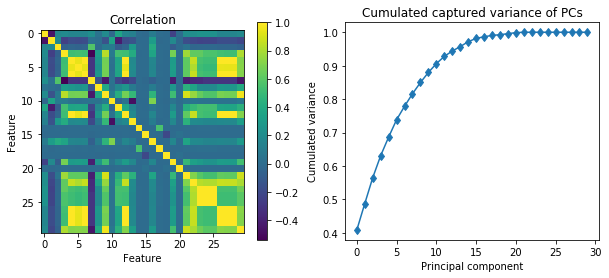

In [4]:
fig = plt.figure(figsize = (10,4))

plt.subplot(121)
plt.imshow(R)
plt.colorbar()
plt.title('Correlation')
plt.xlabel('Feature')
plt.ylabel('Feature')

plt.subplot(122)
plt.plot(cumulativeVariance, '-d')
plt.title('Cumulated captured variance of PCs')
plt.xlabel('Principal component')
plt.ylabel('Cumulated variance')

print('')

There seems to be high correlation between some variables, and the PCA shows that we need way less than 30 principal components to describe a relevant percentage of the variance. This two results lead us to try to delete the highly correlated variables from the dataset. We have also tried, instead, to do the regression with the features given by the PCA, but the results was not promising enough.

<br> <br>
Presence of constant columns when the dataset is splitted in the 3 subsets has been also taken into account. <br> 
This allows us to save a lot of computational effort, since we already have one constant column (added via the function build_poly) in our regression. 

The white zones in the plots refer to constant columns


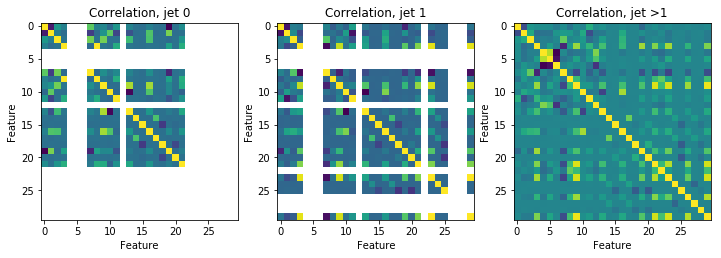

In [5]:
idx0 = np.where(input_data[:,22]==0)
idx1 = np.where(input_data[:,22]==1)
idx2 = np.where(input_data[:,22]>=2)

x0 = input_data[idx0] 
x1 = input_data[idx1] 
x2 = input_data[idx2] 

fig = plt.figure(figsize = (12,4))

plt.subplot(131)
R = np.ma.corrcoef(x0.T)
plt.imshow(R)
plt.title('Correlation, jet 0')
plt.xlabel('Feature')
plt.ylabel('Feature')

plt.subplot(132)
R = np.ma.corrcoef(x1.T)
plt.imshow(R)
plt.title('Correlation, jet 1')
plt.xlabel('Feature')
plt.ylabel('Feature')

plt.subplot(133)
R = np.ma.corrcoef(x2.T)
plt.imshow(R)
plt.title('Correlation, jet >1')
plt.xlabel('Feature')
plt.ylabel('Feature')

print('The white zones in the plots refer to constant columns')

# Set preprocessing parameters

In [6]:
# Do you want to repace the -999 with zeros?
ReplaceToZero_FLAG = True

# Do you want to remove the highly correlated columns from the datasets
RemoveHCColumns_FLAG = True
CorrelationThreshold = 0.8

# Preprocessing
First, we handle the invalid values.

In [7]:
# Reload the data, the first part had explanatory purposes. Here we want to start from scratch, and to repeat step by step
# the manipulations that we applied 
yb, input_data, ids = load_csv_data("../data/train.csv", sub_sample=False)

# Replace -999 with zeros
if ReplaceToZero_FLAG:
    print('Replacing -999 with 0.')
    numInvalidValues=countInvalid(input_data, -999)
    idxCols = np.where(numInvalidValues>0)[0]
    input_data = replaceWithZero(input_data,-999,idxCols)

Replacing -999 with 0.


Now we are going to divide the dataset in 3 different datasets, according to the number of jets. <br><br>
Since in the new division some columns will have constant values, we will also delete those columns and save the indices in order do the same preprocessing when we want to use our model to predict.
<br><br>
Finally, note that we keep the mean and the std of the train set. These parameters will be used to perform the standardization in the prediction phase

In [8]:
idx0 = np.where(input_data[:,22]==0)
idx1 = np.where(input_data[:,22]==1)
idx2 = np.where(input_data[:,22]>=2)

x0 = input_data[idx0] 
x1 = input_data[idx1] 
x2 = input_data[idx2] 

y0 = yb[idx0]
y1 = yb[idx1]
y2 = yb[idx2]

#only the first 2 subsets have const columns
x0, idx_constants_removed0 = removeConstantColumns(x0)
x1, idx_constants_removed1 = removeConstantColumns(x1)


x0, mean_train0, std_train0 = standardize ( x0 )
x1, mean_train1, std_train1 = standardize ( x1 )
x2, mean_train2, std_train2 = standardize ( x2 )

We are left with dealing with the correlated columns.

In [9]:
if RemoveHCColumns_FLAG:
    print('Removing highly correlated columns.')
    x0, idx_HC_removed0 = removeHighCorrelatedColumns(x0, CorrelationThreshold)
    x1, idx_HC_removed1 = removeHighCorrelatedColumns(x1, CorrelationThreshold)
    x2, idx_HC_removed2 = removeHighCorrelatedColumns(x2, CorrelationThreshold)
else:
    idx_HC_removed0 = []
    idx_HC_removed0 = []
    idx_HC_removed0 = []

Removing highly correlated columns.


# Training
Grid search to find the best degree and the best lambda.
<br><br>
For each couple (lambda, degree) we trained the model using <b>ridge regression with 4-fold cross validation</b>. Since this is not a classifier, the goodness of the model is evaluated using the mean of the 4 accuracies (i.e. the percentage of correct predictions) on the validations set of the cross validation.

In [10]:
lambdas0 = np.linspace(1e-5,0.0005,2) 
lambdas1 = np.linspace(1e-5,0.0005,2) 
lambdas2 = np.linspace(1e-5,0.0005,2) 

degrees = np.arange(8,15)
degrees = np.array([1,2])


best_lambda_loss0, best_degree_loss0, best_w_loss0, best_lambda_acc0, best_degree_acc0, best_w_acc0, loss_tr0, loss_te0, accuracy0 = \
grid_search_hyperparam_with_CV(y0, x0, lambdas0, degrees)

best_lambda_loss1, best_degree_loss1, best_w_loss1, best_lambda_acc1, best_degree_acc1, best_w_acc1, loss_tr1, loss_te1, accuracy1 = \
grid_search_hyperparam_with_CV(y1, x1, lambdas1, degrees)

best_lambda_loss2, best_degree_loss2, best_w_loss2, best_lambda_acc2, best_degree_acc2, best_w_acc2, loss_tr2, loss_te2, accuracy2 = \
grid_search_hyperparam_with_CV(y2, x2, lambdas2, degrees)

print('LOSS')
print(f'Model with 0 jets:  lambda = {best_lambda_loss0}, degree = {best_degree_loss0}, loss = {np.min(loss_te0)}')
print(f'Model with 1 jets:  lambda = {best_lambda_loss1}, degree = {best_degree_loss1}, loss = {np.min(loss_te1)}')
print(f'Model with >1 jets: lambda = {best_lambda_loss2}, degree = {best_degree_loss2}, loss = {np.min(loss_te2)}')

print('\n\nACCURACY')
print(f'Model with 0 jets:  lambda = {best_lambda_acc0}, degree = {best_degree_acc0}, accuracy = {np.max(accuracy0)}')
print(f'Model with 1 jets:  lambda = {best_lambda_acc1}, degree = {best_degree_acc1}, accuracy = {np.max(accuracy1)}')
print(f'Model with >1 jets: lambda = {best_lambda_acc2}, degree = {best_degree_acc2}, accuracy = {np.max(accuracy2)}')


N0 = x0.shape[0]
N1 = x1.shape[0]
N2 = x2.shape[0]

#This is a good estimate of the goodness of our model
TOTAccuracy = ( N0*np.max(accuracy0) + N1*np.max(accuracy1) + N2*np.max(accuracy2) ) / ( N0 + N1 + N2 )
print(f'\n\nOur validation set reached a global accuracy of {TOTAccuracy}')

LOSS
Model with 0 jets:  lambda = [0.0005], degree = [1], loss = 0.7378977520486878
Model with 1 jets:  lambda = [0.0005], degree = [2], loss = 0.8277654580398321
Model with >1 jets: lambda = [0.0005], degree = [2], loss = 0.8151215369941737


ACCURACY
Model with 0 jets:  lambda = [1.e-05], degree = [2], accuracy = 0.8252962607094243
Model with 1 jets:  lambda = [1.e-05], degree = [2], accuracy = 0.7521020323945116
Model with >1 jets: lambda = [1.e-05], degree = [2], accuracy = 0.7677970774744969


Our validation set reached a global accuracy of 0.7859085147499725


# Submission

In [ ]:
_, test_data, ids_test = load_csv_data("../data/test.csv", sub_sample=False)
num_tests = test_data.shape[0]

We need to repeat the same manipulations applied on the train set also on the test set.

In [ ]:
# handle invalid data
if ReplaceToZero_FLAG:
    print('Replacing -999 with 0.')
    numInvalidValues=countInvalid(test_data, -999)
    idxCols = np.where(numInvalidValues>0)[0]
    test_data = replaceWithZero(test_data,-999,idxCols)

    
# jets division
idx0 = np.where(test_data[:,22]==0)
idx1 = np.where(test_data[:,22]==1)
idx2 = np.where(test_data[:,22]>=2)
x0 = test_data[idx0] 
x1 = test_data[idx1] 
x2 = test_data[idx2] 

# remove const. columns
x0 = np.delete(x0, idx_constants_removed0, axis=1)
x1 = np.delete(x1, idx_constants_removed1, axis=1)


# standardization with train parameters
x0,_,_ = standardize ( x0, mean_train0, std_train0 )
x1,_,_ = standardize ( x1, mean_train1, std_train1 )
x2,_,_ = standardize ( x2, mean_train2, std_train2 )

# removing higly correlated columns
if(RemoveHCColumns_FLAG):
    print('Removing highly correlated columns.')
    for i in idx_HC_removed0:
        x0 = np.delete(x0,i,axis=1)
    for i in idx_HC_removed1:
        x1 = np.delete(x1,i,axis=1)
    for i in idx_HC_removed2:
        x2 = np.delete(x2,i,axis=1)

Now we need to use the results of the regression to make the prediction

In [ ]:
# augment the feature according to the best degree
x0 = build_poly(x0, int(best_degree_acc0[0]))
x1 = build_poly(x1, int(best_degree_acc1[0]))
x2 = build_poly(x2, int(best_degree_acc2[0]))

# for each subset, predict its output
y_pred0 = predict_labels(best_w_acc0,x0)
y_pred1 = predict_labels(best_w_acc1,x1)
y_pred2 = predict_labels(best_w_acc2,x2)

# recompose the whole predicion
y_pred = np.ones(num_tests)
y_pred[idx0] = y_pred0
y_pred[idx1] = y_pred1
y_pred[idx2] = y_pred2

In [ ]:
create_csv_submission(ids_test, y_pred, 'FinalModel.csv')